In [2]:
!pip install datasets evaluate sentence_transformers > None
!pip uninstall -y transformers accelerate
!pip install transformers accelerate


Found existing installation: transformers 4.41.2
Uninstalling transformers-4.41.2:
  Successfully uninstalled transformers-4.41.2
Found existing installation: accelerate 0.31.0
Uninstalling accelerate-0.31.0:
  Successfully uninstalled accelerate-0.31.0
  Using cached transformers-4.41.2-py3-none-any.whl (9.1 MB)
  Using cached accelerate-0.31.0-py3-none-any.whl (309 kB)


In [3]:
import torch


In [16]:
from datasets import load_dataset

dataset = load_dataset("halaction/song-lyrics")

In [ ]:
dataset

In [17]:
dataset = dataset.rename_column("genre", "label")

In [18]:
dataset = dataset.rename_column("lyrics", "text")

In [19]:
d_rock=dataset['train'].filter(lambda example: example["label"].startswith("Rock"))

In [20]:
small_rock_dataset = d_rock.select(range(500))

In [21]:
d_pop=dataset['train'].filter(lambda example: example["label"].startswith("Pop"))

In [22]:
small_pop_dataset = d_pop.select(range(500))

In [23]:
d_hip_hop=dataset['train'].filter(lambda example: example["label"].startswith("Hip"))

In [24]:
small_hip_hop_dataset = d_hip_hop.select(range(500))

In [25]:
d_indie=dataset['train'].filter(lambda example: example["label"].startswith("Indie"))

In [26]:
small_indie_dataset = d_indie.select(range(500))

In [27]:
d_metal=dataset['train'].filter(lambda example: example["label"].startswith("Heavy"))

Filter:   0%|          | 0/48487 [00:00<?, ? examples/s]

In [28]:
small_metal_dataset = d_metal.select(range(500))

In [29]:
d_dance=dataset['train'].filter(lambda example: example["label"].startswith("Dance"))

Filter:   0%|          | 0/48487 [00:00<?, ? examples/s]

In [30]:
small_dance_dataset = d_dance.select(range(500))

In [31]:
from datasets import concatenate_datasets

In [32]:
ddd = concatenate_datasets([small_pop_dataset, small_rock_dataset, small_indie_dataset, small_metal_dataset, small_dance_dataset, small_hip_hop_dataset])


In [33]:
ddd

Dataset({
    features: ['text', 'label'],
    num_rows: 3000
})

In [34]:
dataset = ddd.class_encode_column("label")

Flattening the indices:   0%|          | 0/3000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [35]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [36]:
data_shuffle=tokenized_datasets.shuffle()

In [37]:
data_split = data_shuffle.train_test_split(test_size=0.5)


In [38]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=6)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

In [40]:
from sklearn.metrics import confusion_matrix


In [41]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)



In [42]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [43]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data_split['train'],
    eval_dataset=data_split['test'],
    compute_metrics=compute_metrics,
)

In [44]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.489345,0.394667
2,No log,1.429074,0.356000
3,1.509600,1.406994,0.414000


TrainOutput(global_step=564, training_loss=1.4817444686348558, metrics={'train_runtime': 589.1108, 'train_samples_per_second': 7.639, 'train_steps_per_second': 0.957, 'total_flos': 1184042271744000.0, 'train_loss': 1.4817444686348558, 'epoch': 3.0})

Было интересно посмотреть на матрицу ошибок, её удалось создать только в отдельном коде, работая в jupyter notebook (немного не разобралась, как создать тут), поэтому прикрепляю изображение.

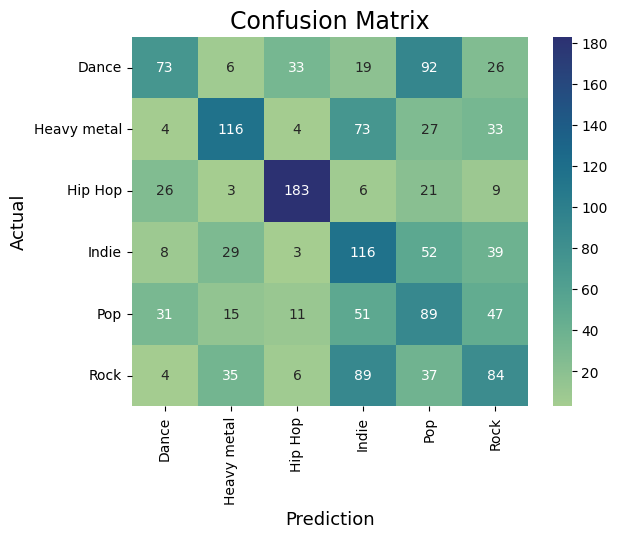